In [13]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn

### Load and Display Images

In [14]:
salinas = np.load('salinas.npy', allow_pickle=True)
salinas_gt = np.load('salinas_gt.npy', allow_pickle=True)
print(salinas.shape)
print(salinas_gt.shape)

(512, 217, 204)
(512, 217)


In [15]:
indiana_pines = np.load('indianapines.npy', allow_pickle=True)
indiana_pines_gt = np.load('indianapines_gt.npy', allow_pickle=True)
print(indiana_pines.shape)
print(indiana_pines_gt.shape)

(145, 145, 200)
(145, 145)


In [16]:
def plot_RGB(image):
    imageRGB = np.array(image[:, :, [30, 15, 2]], dtype=float)

    pmin,pmax = np.percentile(imageRGB, (1,99), axis=(0,1))
    print(pmin, pmax)
    imageRGB_pimped = imageRGB.copy()

    for i in range(pmin.size):
        imageRGB_pimped[:,:,i] = (imageRGB[:,:,i] - pmin[i]) / (pmax[i] - pmin[i])

    imageRGB_pimped[imageRGB_pimped < 0] = 0
    imageRGB_pimped[imageRGB_pimped > 1] = 1

    plt.figure(figsize=(5,5))
    plt.imshow(imageRGB_pimped)
    plt.show()

[ 600. 1045.  474.] [3747. 3107.  927.]


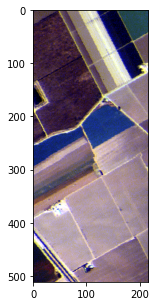

In [17]:
plot_RGB(salinas)

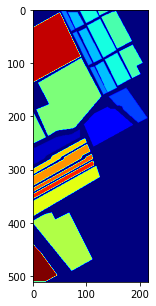

In [138]:
plt.figure(figsize=(5,5))
plt.imshow(salinas_gt, cmap='jet')

[2353. 2761. 3833.] [5442.   6051.76 4946.  ]


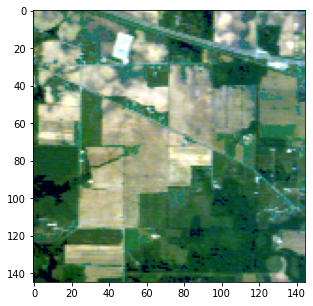

In [140]:
plot_RGB(indiana_pines)

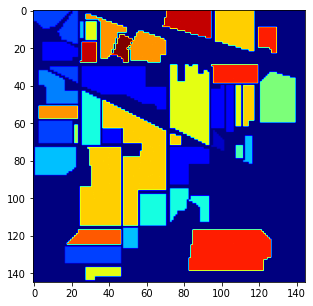

In [141]:
plt.figure(figsize=(5,5))
plt.imshow(indiana_pines_gt, cmap='jet')

### PCA

In [19]:
def flatten_image(X):
    return X.reshape((-1, X.shape[-1]))

X1 = flatten_image(salinas)
Y1 = salinas_gt.flatten()
print(X1.shape)
print(Y1.shape)

X2 = flatten_image(indiana_pines)
Y2 = indiana_pines_gt.flatten()
print(X2.shape)
print(Y2.shape)

(111104, 204)
(111104,)
(21025, 200)
(21025,)


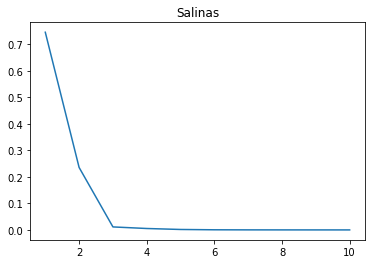

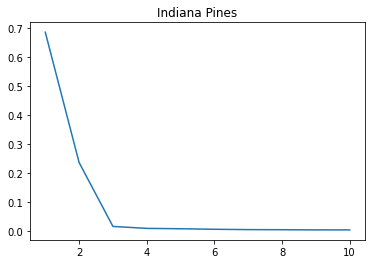

In [20]:
from sklearn import decomposition

def pca_components(X, name):
    pca = decomposition.PCA(n_components=10)
    pca.fit(X)

    plt.plot(np.arange(1, 11), pca.explained_variance_ratio_)
    plt.title(name)
    plt.show()

pca_components(X1, "Salinas")
pca_components(X2, "Indiana Pines")

Variance greater than 0.999: 5


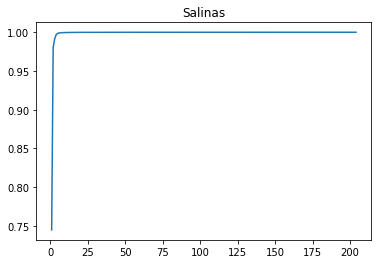

Variance greater than 0.999: 68


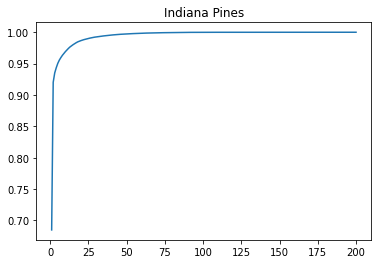

In [21]:
def pca_components_cumsum(X, name):
    pca = decomposition.PCA()
    pca.fit(X)

    variances = np.cumsum(pca.explained_variance_ratio_)
    print("Variance greater than 0.999:", np.argmax(variances > 0.999))

    plt.plot(np.arange(1, X.shape[-1] + 1), variances)
    plt.title(name)
    plt.show()

pca_components_cumsum(X1, "Salinas")
pca_components_cumsum(X2, "Indiana Pines")

In [22]:
pca1 = decomposition.PCA(n_components=20)
pca1.fit(X1)
print(pca1.components_.shape)

X1_pca = pca1.transform(X1)
print(X1_pca.shape)

(20, 204)
(111104, 20)


In [23]:
pca2 = decomposition.PCA(n_components=68)
pca2.fit(X2)
print(pca2.components_.shape)

X2_pca = pca2.transform(X2)
print(X2_pca.shape)

(68, 200)
(21025, 68)


## Custom classifier

In [74]:
from sklearn.preprocessing import LabelBinarizer

labelBinarizer = LabelBinarizer(sparse_output=False)
y2_bin = labelBinarizer.fit_transform(Y2)
columns = y2_bin.T

print(columns.shape)
print(type(columns))
print(y2_bin[:10])
print(columns[3,:10])
print(columns[0].shape)

(17, 21025)
<class 'numpy.ndarray'>
[[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[1 1 1 1 1 1 1 1 1 1]
(21025,)


In [121]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import clone

class MyClassifier(BaseEstimator):
    def __init__(self, clf, class_weights=None):
        self.clf_ = clf
        self.class_weights_ = class_weights
    
    def fit(self, X, y):
        self.label_binarizer_ = LabelBinarizer(sparse_output=False)
        Y = self.label_binarizer_.fit_transform(y)
        #self.classes_ = self.label_binarizer_.classes_
        columns = Y.T
        self.estimators_ = []
        #for i, y_bin in enumerate(columns[1:]):
        for i, y_bin in enumerate(columns):
            print(i)
            clf_copy = clone(self.clf_)
            self.estimators_.append(clf_copy.fit(X, y_bin))
            
#         self.estimators_ = Parallel(n_jobs=self.n_jobs)(delayed(_fit_binary)(
#             self.estimator, X, column, classes=[
#                 "not %s" % self.label_binarizer_.classes_[i],
#                 self.label_binarizer_.classes_[i]])
#             for i, column in enumerate(columns))

#         return self

        
    def predict(self, X):
        maxima = np.full(X.shape[0], -np.inf)
        argmaxima = np.zeros(X.shape[0], dtype=int)
        
        for i, e in enumerate(self.estimators_):
            proba_y = e.predict_proba(X)[:,1]
            np.maximum(maxima, proba_y, out=maxima)
            argmaxima[maxima == proba_y] = i
            
        #argmaxima[maxima < 0.5] = 0
        return argmaxima
    
    def score(self, X, Y_true):
        y_pred = self.predict(X)
        return np.sum(y_pred == Y_true) / len(Y_true)


In [127]:
from sklearn.calibration import CalibratedClassifierCV

clf = MyClassifier(CalibratedClassifierCV(LinearSVC(random_state=1, max_iter=1000), cv=3, n_jobs=5))

In [128]:
clf.fit(X2, Y2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [142]:
y2_predict = clf.predict(X2)
clf.score(X2, Y2)

0.7357431629013079

(21025,)
(145, 145)


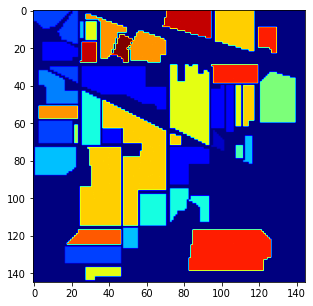

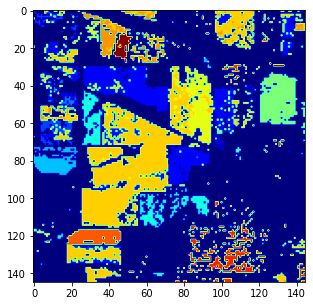

In [148]:
print(y2_predict.shape)
y2_predict_reshaped = y2_predict.reshape((indiana_pines_gt.shape))
print(y2_predict_reshaped.shape)
plt.figure(figsize=(5,5))
plt.imshow(indiana_pines_gt, cmap='jet')
plt.show()
plt.figure(figsize=(5,5))
plt.imshow(y2_predict_reshaped, cmap='jet')
plt.show()

### Classifier

In [24]:
from sklearn import utils

def class_weights(y):
    class_weights = utils.class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weights = dict(zip(np.arange(16), class_weights))

    print(class_weights)

    return class_weights

class_weights1 = class_weights(Y1)
class_weights2 = class_weights(Y2)

{0: 0.11470872157551042, 1: 3.2531256405001026, 2: 1.7540336585519876, 3: 3.3074541557513695, 4: 4.68832812895603, 5: 2.4404516100689717, 6: 1.650803084557895, 7: 1.826076952155548, 8: 0.5798535544108514, 9: 1.0536078368152033, 10: 1.9937551591716614, 11: 6.11940956157744, 12: 3.3915565188192556, 13: 7.134857436424351, 14: 6.107971412864211, 15: 0.8992197869791835}
{0: 0.11477029564609809, 1: 26.88618925831202, 2: 0.8660817268083704, 3: 1.490077958894401, 4: 5.218416480516257, 5: 2.5605894531725735, 6: 1.6941982272361, 7: 44.17016806722689, 8: 2.5873738616785626, 9: 61.838235294117645, 10: 1.27239167271847, 11: 0.5037738109500419, 12: 2.08560658664815, 13: 6.032998565279771, 14: 0.9776796093931643, 15: 3.2040536421822616}


In [25]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(shuffle=True, early_stopping=True, class_weight=class_weights1, random_state=1)

### One vs rest classifier

In [92]:
from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier(LinearSVC(random_state=1, max_iter=100), n_jobs=4)

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

clf_pipeline = OneVsRestClassifier(LinearSVC(random_state=1, max_iter=1000), n_jobs=4)
clf = make_pipeline(StandardScaler(), clf_pipeline)

### One vs one classifier


In [33]:
from sklearn.multiclass import OneVsOneClassifier

clf_pipeline = OneVsOneClassifier(LinearSVC(random_state=1, max_iter=1000), n_jobs=6)
clf = make_pipeline(StandardScaler(), clf_pipeline)

In [34]:
clf.fit(X1, Y1)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('onevsoneclassifier',
                 OneVsOneClassifier(estimator=LinearSVC(random_state=1),
                                    n_jobs=6))])

In [93]:
clf.fit(X2, Y2)

OneVsRestClassifier(estimator=LinearSVC(max_iter=100, random_state=1), n_jobs=4)

0.8952512960829493
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     56975
           1       0.83      1.00      0.91      2009
           2       0.93      0.99      0.96      3726
           3       0.71      0.53      0.61      1976
           4       0.87      0.89      0.88      1394
           5       0.85      0.91      0.88      2678
           6       0.92      0.98      0.95      3959
           7       0.94      0.98      0.96      3579
           8       0.79      0.89      0.84     11271
           9       0.93      0.89      0.91      6203
          10       0.92      0.85      0.88      3278
          11       0.92      0.90      0.91      1068
          12       0.85      0.75      0.80      1927
          13       0.78      0.87      0.82       916
          14       0.83      0.84      0.84      1070
          15       0.81      0.66      0.72      7268
          16       0.93      0.97      0.95      1807

    acc

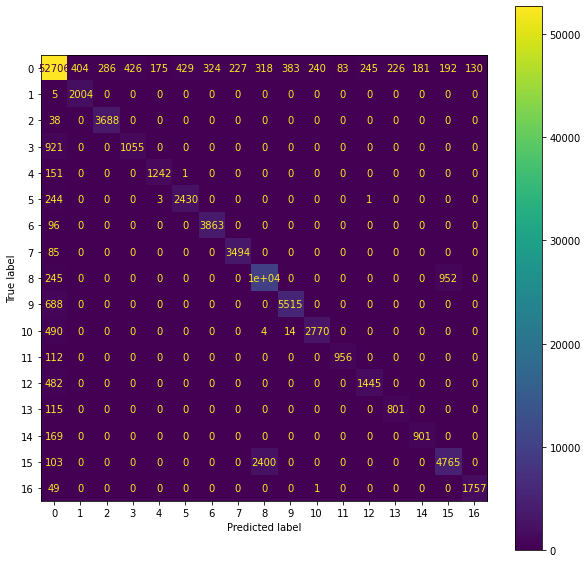

In [35]:
from sklearn.metrics import plot_confusion_matrix, classification_report

print(clf.score(X1, Y1))
print(classification_report(Y1, clf.predict(X1)))
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf, X1, Y1, ax=ax)
plt.show()

0.5245184304399524
              precision    recall  f1-score   support

           0       0.93      0.48      0.63     10776
           1       0.03      0.02      0.03        46
           2       0.67      0.25      0.36      1428
           3       0.12      0.02      0.03       830
           4       0.21      0.11      0.14       237
           5       0.43      0.70      0.53       483
           6       0.47      0.95      0.63       730
           7       0.16      0.29      0.21        28
           8       0.63      1.00      0.77       478
           9       0.12      0.20      0.15        20
          10       0.33      0.01      0.01       972
          11       0.30      0.98      0.46      2455
          12       0.56      0.06      0.11       593
          13       0.51      0.98      0.67       205
          14       0.41      0.94      0.57      1265
          15       0.28      0.09      0.14       386
          16       0.74      0.80      0.77        93

    acc

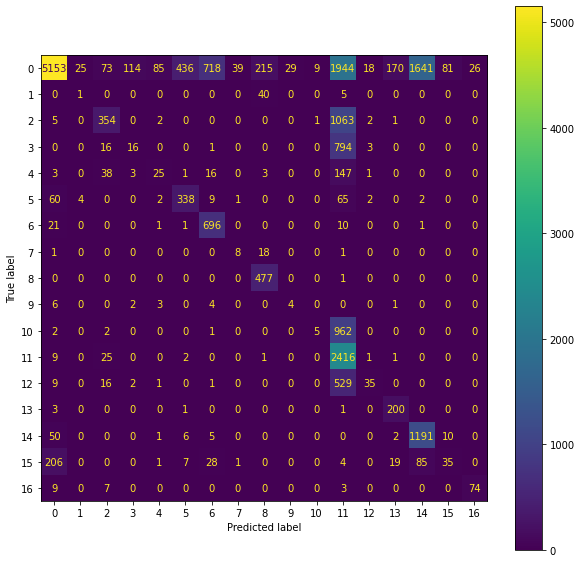

In [94]:
print(clf.score(X2, Y2))
print(classification_report(Y2, clf.predict(X2)))
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf, X2, Y2, ax=ax)
plt.show()